<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

<hr>
<h3>Для начала я добавил архив с датасетом к себе на Google Drive. Далее реализовал метод по получению объекта data loader с загруженными картинками.</h3>

<hr>
<p>Получаю доступ к архиву и разархивирую его</p>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
sample_dir = 'data_gan'
os.makedirs(sample_dir, exist_ok=True)

In [4]:
!unzip "/content/drive/MyDrive/Colab Notebooks/GUN/archive.zip" -d '/content/data_gan/'

Archive:  /content/drive/MyDrive/Colab Notebooks/GUN/archive.zip
  inflating: /content/data_gan/faces_dataset_small/00055.png  
  inflating: /content/data_gan/faces_dataset_small/00237.png  
  inflating: /content/data_gan/faces_dataset_small/00240.png  
  inflating: /content/data_gan/faces_dataset_small/00241.png  
  inflating: /content/data_gan/faces_dataset_small/00242.png  
  inflating: /content/data_gan/faces_dataset_small/00243.png  
  inflating: /content/data_gan/faces_dataset_small/00244.png  
  inflating: /content/data_gan/faces_dataset_small/00245.png  
  inflating: /content/data_gan/faces_dataset_small/00246.png  
  inflating: /content/data_gan/faces_dataset_small/00247.png  
  inflating: /content/data_gan/faces_dataset_small/00248.png  
  inflating: /content/data_gan/faces_dataset_small/00249.png  
  inflating: /content/data_gan/faces_dataset_small/00253.png  
  inflating: /content/data_gan/faces_dataset_small/00255.png  
  inflating: /content/data_gan/faces_dataset_small/00

<hr>
<h3>Реализовываю необходимый метод, который будет нам возвращать объект data loader. Над изображениями произвожу нужные преобразования после чего уже загружаю в DataLoader</h3>

In [5]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader
  
  INP_DIR = '/content/data_gan'

  transform_img = tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.ToTensor(),
      tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  data_set = ImageFolder(root=INP_DIR, transform=transform_img)
  
  data_loader = DataLoader(data_set, batch_size, shuffle=True, num_workers=2)

  return data_loader

In [6]:
#TODO: build dataloader and transfer it to device
image_size = 128
batch_size = 32

train_dl = get_dataloader(image_size, batch_size)

<hr>
<h3>Теперь давайте посмотрим полученные картинки из датасета. Выведим батч картинок (32 шт.)</h3>

In [7]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(13, 13))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

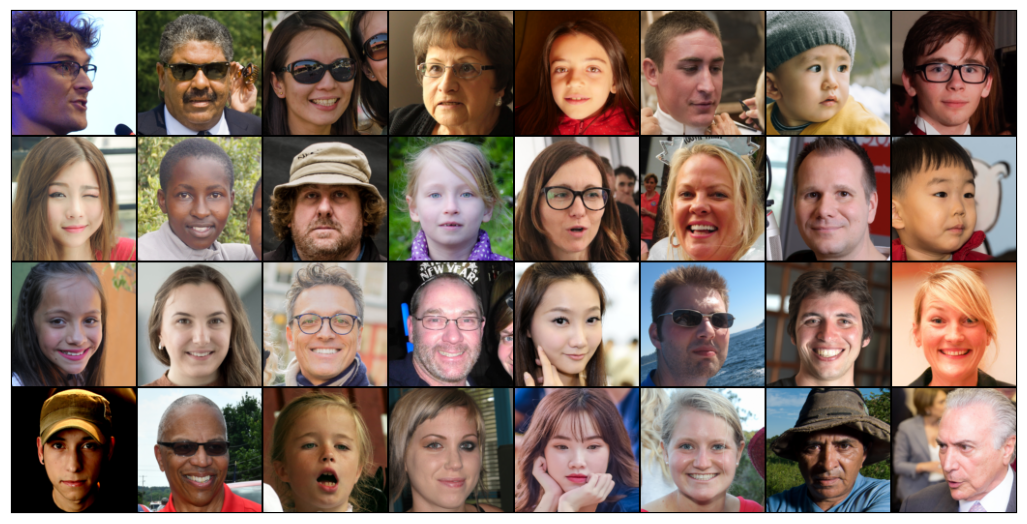

In [8]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [9]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}.")

Device: cuda.


<hr>
<h3>Тут будет реализованы генератор и дискриминатор при помощи: Conv2d, LeakyReLU, BatchNorm2d, ConvTranspose2d, ReLU. Функциями активации будут выступать сигмоида и гиперболический тангенс.</h3>
<hr>
<p>Размер латентного пространства выберу = 100</p>

In [10]:
discriminator = nn.Sequential(
    
    # in: 3 x 128 x 128
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Sigmoid()
)

In [11]:
latent_size = 100 # choose latent size

generator = nn.Sequential(
    # in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4
    
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # out: 3 x 128 x 128

    nn.Tanh()
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

<hr>
<h2>Теперь получу объекты дискриминатора и генератора, их оптимайзеры и функцию потерь. Оптимизаторами будут Adam, а функцией потерь выступить BCELoss.<h2>
<hr>
<p>Learning rate выберу равным 0.0002.</p>

In [12]:
lr = 2e-4

gunD = discriminator.to(device)
gunG = generator.to(device)

criterion = nn.BCELoss()

optimizerD = torch.optim.Adam(discriminator.parameters(), 
                              lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(),
                              lr=lr, betas=(0.5, 0.999))

<hr>
<h3>Теперь реализую метод обучения где дополнительно будут сохранятся полученные картинки генератора с каждой эпохи для наглядного прогресса.</h3>
<hr>

In [13]:
def fit(mod_discriminator, mod_generator, opt_discriminator, opt_generator, criterion, epochs, lr):
  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
    
  for epoch in range(epochs):
      loss_d_per_epoch = []
      loss_g_per_epoch = []
      real_score_per_epoch = []
      fake_score_per_epoch = []

      for real_images, _ in tqdm(train_dl):
          # Train discriminator
          mod_discriminator.zero_grad()

          real_images = real_images.to(device)
          batch_s = real_images.size(0)

          label = torch.full((batch_s, ), 1, dtype=torch.float, device=device)
          real_preds = mod_discriminator(real_images).view(-1)
          real_loss = criterion(real_preds, label)
          cur_real_score = torch.mean(real_preds).item()
          real_loss.backward()

          # Generate fake images
          latent = torch.randn(batch_s, latent_size, 1, 1, device=device)
          fake_images = mod_generator(latent)

          # Pass fake images through discriminator
          label.fill_(0)
          fake_preds = mod_discriminator(fake_images.detach()).view(-1)
          fake_loss = criterion(fake_preds, label)
          fake_loss.backward()
          cur_fake_score = torch.mean(fake_preds).item()

          real_score_per_epoch.append(cur_real_score)
          fake_score_per_epoch.append(cur_fake_score)

          # Update discriminator weights
          loss_d = real_loss + fake_loss
          opt_discriminator.step()
          loss_d_per_epoch.append(loss_d.item())

          # Train generator
          mod_generator.zero_grad()
          label.fill_(1)

          # Try to fool the discriminator
          preds = mod_discriminator(fake_images).view(-1)
          loss_g = criterion(preds, label)
          loss_g.backward()
          
          # Update generator weights
          loss_g_per_epoch.append(loss_g.item())
          opt_generator.step()
          
      # Record losses & scores
      losses_g.append(np.mean(loss_g_per_epoch))
      losses_d.append(np.mean(loss_d_per_epoch))
      real_scores.append(np.mean(real_score_per_epoch))
      fake_scores.append(np.mean(fake_score_per_epoch))

      with torch.no_grad():
        z = torch.randn(batch_size, latent_size, 1, 1, device=device)
        fake_images = mod_generator(z)
        save_image(denorm(fake_images).view(fake_images.size(0), 3, 128, 128), f"generated_images_{epoch+1}.png")
      
      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, 
          losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
      
  return losses_g, losses_d, real_scores, fake_scores, mod_discriminator, mod_generator

<hr>
<p>Ниже я загружаю уже ранее обученный мною дискриминатор и генератор. Всего у меня есть 6 моделей: 50,70,80,90,100 и 110. Так же загружаю показатели различных значений после обучения. Просто после каждого обучения новой модели мне легче было перезапустить colab чем очищать его.</p>

In [14]:
checkpoint = torch.load('/content/drive/MyDrive/models_110.pth')
gunD.load_state_dict(checkpoint['discriminator'])
gunG.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

In [15]:
data = torch.load('/content/drive/MyDrive/data_110.pth')
losses_g_110 = data['losses_g']
losses_d_110 = data['losses_d']
real_scores_110 = data['real_scores']
fake_scores_110 = data['fake_scores']

<hr>
<h2>Обучем же наше изделие!</h2>

In [ ]:
losses_g, losses_d, real_scores, fake_scores, trained_discriminator, trained_generator = fit(gunD, gunG, optimizerD, optimizerG, criterion, 10, lr)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 7.6455, loss_d: 0.1348, real_score: 0.9540, fake_score: 0.0431


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 7.4841, loss_d: 0.2255, real_score: 0.9549, fake_score: 0.0524


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 7.5663, loss_d: 0.0714, real_score: 0.9729, fake_score: 0.0259


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 9.7180, loss_d: 0.1539, real_score: 0.9578, fake_score: 0.0406


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 8.6273, loss_d: 0.2062, real_score: 0.9475, fake_score: 0.0532


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 8.4781, loss_d: 0.1055, real_score: 0.9649, fake_score: 0.0347


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 7.6398, loss_d: 0.0533, real_score: 0.9778, fake_score: 0.0217


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 9.1176, loss_d: 0.0818, real_score: 0.9727, fake_score: 0.0271


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 10.1473, loss_d: 0.3046, real_score: 0.9362, fake_score: 0.0638


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 9.1865, loss_d: 0.0982, real_score: 0.9663, fake_score: 0.0344


p.s.: здесь была обучена последняя модель со 110 эпохами в сумме.

In [ ]:
gunD = trained_discriminator
gunG = trained_generator

In [16]:
trained_discriminator = gunD
trained_generator = gunG

In [ ]:
losses_g_110 = losses_g_110 + losses_g
losses_d_110 = losses_d_110 + losses_d
real_scores_110 = real_scores_110 + real_scores
fake_scores_110 = fake_scores_110 + fake_scores

<p>Здесь я совмещаю показатели с предыдущих обучений с нынешними.</p>
<hr>

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

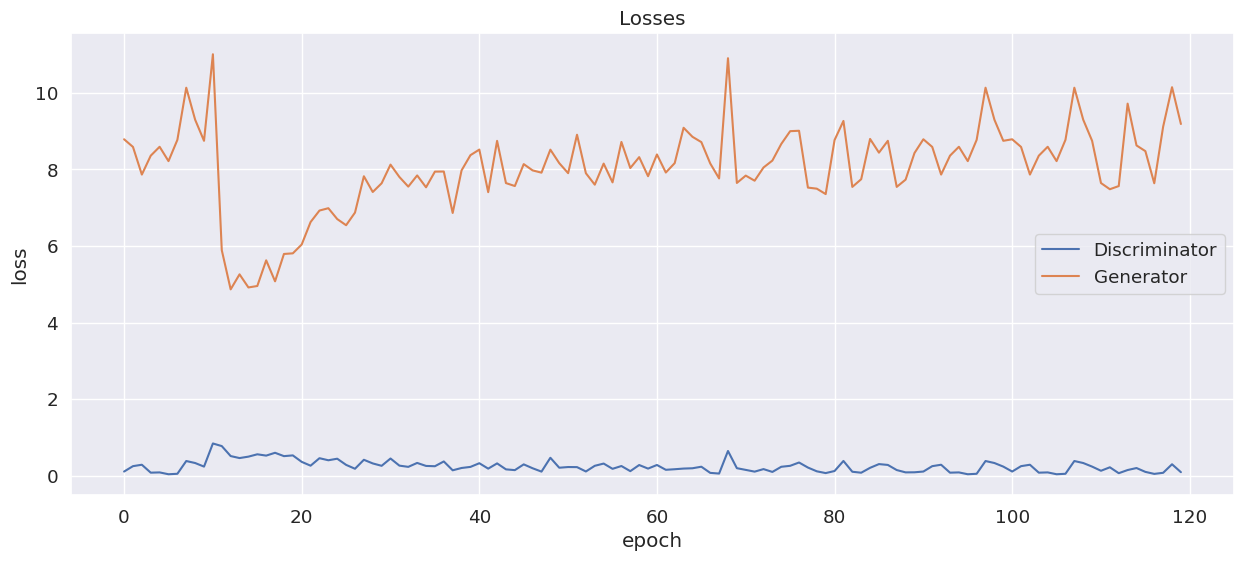

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d_110, '-')
plt.plot(losses_g_110, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

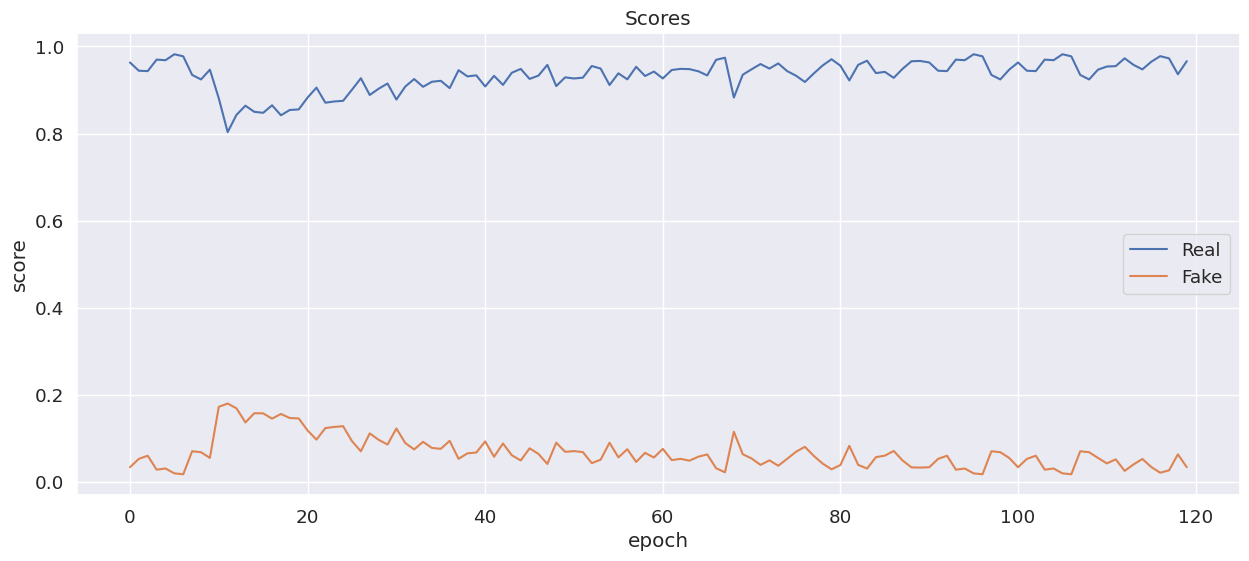

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores_110, '-')
plt.plot(fake_scores_110, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

<p>Как мы видим из-за противостояни между дискриминатором и генератором присутствует. Вероятность принадлежности фэйковых изображений к классу 1-н с каждой эпохой стремится к 0-лю, а у реальных изображений к 1-це.<br>Так же у генератора loss в самом начале резко падает, после чего из-за борьбы стабилизируется, как и у дискриминатора.<br>То есть модели обучались достаточно хорошо и наблюдался прогресс. Но чем дальше они учатся, тем медленнее становиться прогресс.</p>
<hr>

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

<hr>
<h2>Здесь я реализовал получение из рандомного латентного пространства через генератор новое изображение.</h2>

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = gunG(fixed_latent)

In [ ]:
def show_images(generated):
  # TODO: show generated images
  fig, axes = plt.subplots(nrows=1, ncols=generated.shape[0], figsize=(10, 5))
  for i, ax in enumerate(axes):
    img = np.transpose(generated[i].detach().cpu().numpy(), (1, 2, 0))
    img = (img + 1) / 2  # переводим из [-1, 1] в [0, 1]
    ax.imshow(img)
    ax.axis('off')
  plt.show()  

In [ ]:
print(fake_images.shape)

torch.Size([4, 3, 128, 128])


<h3>Ниже будут показаны генерации различных моделей, начиная с 70, заканчивая 110.</h3>

<hr>
<h3><b>70</b> эпох обучения:</h3>

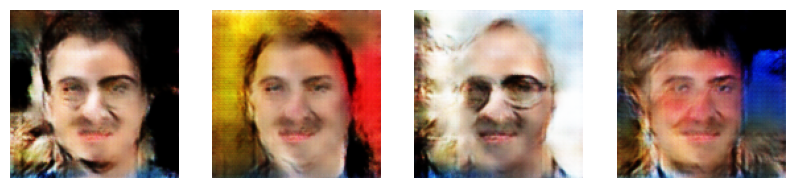

In [ ]:
show_images(fake_images.to('cpu'))

<hr>
<h3><b>80</b> эпох обучения:</h3>

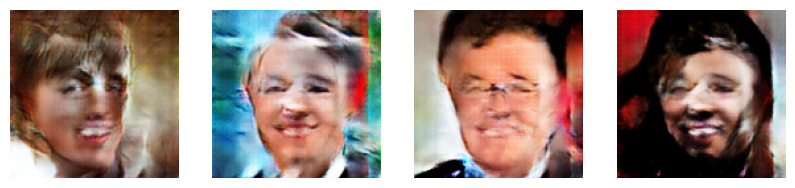

In [ ]:
show_images(fake_images.to('cpu'))

<hr>
<h3><b>90</b> эпох обучения:</h3>

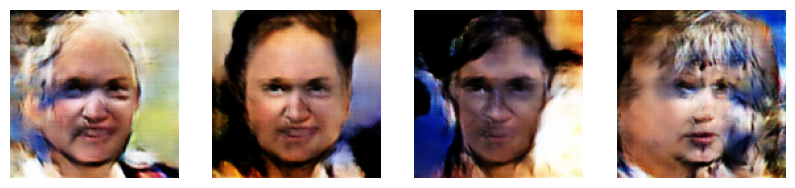

In [ ]:
show_images(fake_images.to('cpu'))

<hr>
<h3><b>100</b> эпох обучения:</h3>

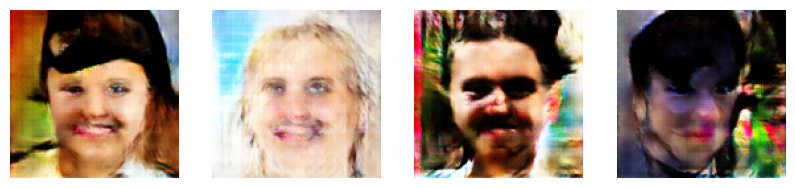

In [ ]:
show_images(fake_images.to('cpu'))

<hr>
<h3><b>110</b> эпох обучения:</h3>

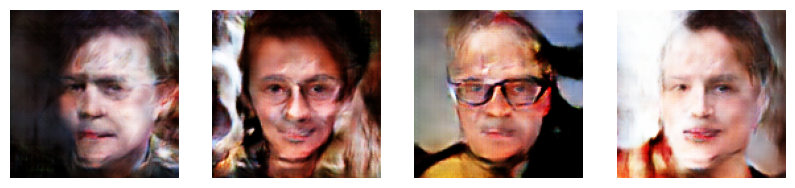

In [ ]:
show_images(fake_images.to('cpu'))

<hr>
<h3>Как мы видим генератор научился из фейкового латентного пространства генерировать новые лица, но с артефактами. Наблюдаются проблемы с генерацией заднего фона, а также качеством лица. Но все же отмечу, что он умеет генерировать все основные черты лица, даже иногда аксессуары в виде очков. Для самой просто модели это хороший показатель.</h3>

<hr>
<p>Здесь я сохраняю мои результаты</p>

In [ ]:
torch.save({
    'discriminator': trained_discriminator.state_dict(),
    'generator': trained_generator.state_dict(),
}, 'models_110.pth')

In [ ]:
torch.save({
    
    'losses_g':  losses_g + losses_g_110,
    'losses_d':  losses_d + losses_d_110,
    'real_scores': real_scores + real_scores_110,
    'fake_scores': fake_scores + fake_scores_110,
}, 'data_110.pth')

Как вам качество получившихся изображений?

<hr>
<p>Не смотря на простоту модели, генератор справляется со своей задачей и может генерировать что-то похожее на лицо человека соблюдая все его основные черты. Наблюдаются некоторые артефакты, а также проблемы с задним фоном из-за простоты модели.</p>

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

<hr>
<p>На этом этапе я решил сохранить полученные изображения.</p>

In [ ]:
!zip -r '/content/trained_pictures_110.zip' '/content/trained_pictures/'

  adding: content/trained_pictures/ (stored 0%)
  adding: content/trained_pictures/generated_images_6.png (deflated 0%)
  adding: content/trained_pictures/generated_images_5.png (deflated 0%)
  adding: content/trained_pictures/generated_images_2.png (deflated 0%)
  adding: content/trained_pictures/generated_images_7.png (deflated 0%)
  adding: content/trained_pictures/generated_images_3.png (deflated 0%)
  adding: content/trained_pictures/generated_images_10.png (deflated 0%)
  adding: content/trained_pictures/generated_images_8.png (deflated 0%)
  adding: content/trained_pictures/.ipynb_checkpoints/ (stored 0%)
  adding: content/trained_pictures/generated_images_4.png (deflated 0%)
  adding: content/trained_pictures/generated_images_1.png (deflated 0%)
  adding: content/trained_pictures/generated_images_9.png (deflated 0%)


Все полученные изображения с каждой модели будут выложены на <a href="https://github.com/VladMartinov/DL.GUN">git-репозитории</a> для дальнейшего ознакомления.
<hr>

<h2>Здесь я произведу подсчёт accuracy своей модели придерживаясь выше указанному плану.</h2>

In [17]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [18]:
n_images = 1600

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = trained_generator(fixed_latent)

In [19]:
reshaped_fake = fake_images.reshape(fake_images.shape[0], -1)

real_images = [i[0] for i in tqdm(train_dl)][:int(n_images/batch_size)]

100%|██████████| 99/99 [02:06<00:00,  1.27s/it]


In [20]:
reshaped_real = torch.stack(real_images).reshape(fake_images.shape[0], -1)

In [21]:
assert reshaped_real.shape == reshaped_fake.shape

In [25]:
fake_labels = np.zeros(n_images)
real_labels = np.ones(n_images)
labels = np.concatenate([fake_labels, real_labels])

features = torch.concat([reshaped_fake.cpu(), reshaped_real.cpu()]).detach().numpy()

loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

In [26]:
%%time
# Обучаем и оцениваем классификатор с помощью leave-one-out оценки
accuracies = []
for train_index, test_index in loo.split(features):
    print("\tTRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

	TRAIN: [   1    2    3 ... 3197 3198 3199] TEST: [0]
	TRAIN: [   0    2    3 ... 3197 3198 3199] TEST: [1]
	TRAIN: [   0    1    3 ... 3197 3198 3199] TEST: [2]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [3]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [4]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [5]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [6]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [7]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [8]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [9]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [10]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [11]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [12]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [13]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [14]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [15]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [16]
	TRAIN: [   0    1    2 ... 3197 3198 3199] TEST: [17]
	TRAIN: [   0    1  

In [27]:
mean_accuracy = np.mean(accuracies)
print("Accuracy:", mean_accuracy)

Accuracy: 0.8690625


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

<p>Полученный результат я считаю очень хороший. Большую часть фековых изображений (а именно 1181 изображение из 1600 фековых) он распознал как истинные картинки. Это значит, что наш генератор достаточно хорошо генерирует изображения из рандомного латентного пространства. Таким образом наш генератор обучился правильно и способен воссоздавать лица похожие на исходные. Конечно не идеально, но для своей структуры очень хорошо.</p>
<hr>

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

<h3>Ниже будет показана визуализация распределений каждой модели начиная с последней, заканчивая 70 эпох, для более детального изучения результатов.</h3>

<hr>
<h3><b>110</b> эпох:</h3>

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

<hr>
<h3><b>100</b> эпох:</h3>

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

<hr>
<h3><b>90</b> эпох:</h3>

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

<hr>
<h3><b>80</b> эпох:</h3>

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

<hr>
<h3><b>70</b> эпох:</h3>

In [ ]:
fig = px.scatter(tsne_results, x=0, y=1, color=y.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

Прокомментируйте получившийся результат:

<hr>
<h2><b>Подведём итоги домащнего задания</b></h2>
<hr>
<h2>Подводя итоги домашнего задания мне уздалось обучить простой GUN, а так же узнать его accuracy и увидеть распределение фейковых и обычных картинок на плоскости.</h2>
<hr>
<h3>Исходя из полученного accuracy мы так же можем утверждать, что наши модели достаточно хорошо обучились и способны воссоздавать из рандомных латентных пространств лица похожие на настоящие.</h3>
<hr>
<h4>Выполнив анализ распределений на плоскости можно выявить следующее:</h4>
<ul>
  <li><p>На 90 и 80 эпохах наши фэйковые картинки довольно легко отличить от настоящих.</p></li>
  <li><p>На удивление, на 70 эпохе результат был лучше. Тут уже картинки начали смешиваться между собой, это означает, что наш генератор научился генерировать картинки схожие с настоящими.</p></li>
  <li><p>На 110 и 100 эпохах наши изображения начинают смешиваться лучше. Все еще не наблюдается идельного распределения точек, где невозможно отличить фейк от настоящей. Но результат для данной модели я считаю достойный. Ведь уже становиться труднее отличать настоящую от фейка.</p></li>
</ul>
<hr>
<h4>Данный результа можно улучшить следующим способом. Выбрать другой лосс допустим не BCELoss а MSELoss, как было сказано в лекции, чтобы он генерировал не одно и тоже изображение а различные. Т.к. если присмотреться на генерируемые изображения, то мы можем наблюдать, что они в чем-то схожи. Можно еще другую структуру реализовать для того, чтобы данные модели могли хорошо генерировать задний фон, т.к. эти модели в основном обучается генерировать из шума черты лица, а вот задний фон она не генерирует вовсе. Так же для улучшения можно еще добавить буфер, более больше датасет, а так же можно вовсе использовать другую сетку для дискриминатора.</h4>
<hr>
<p>Результат генерации картинок на каждой эпохе будут лежат на <a href="https://github.com/VladMartinov/DL.GUN">git-репозитории</a>, где будет вылажены так же обученные модели и loss, и т.п. При помощи изображений можно будет увидеть как прогрессирует наши модели.<br>В дальнейшем можно будет поэксперементировать с самой структурой, т.к. базовая не выдаёт идельный результат и обучение достаточно долгое.</p>
<hr>
p.s.: Я только сейчас обратил внимание, что везде называл gun вместо gan 😆 Явно мне нравилось ассоциировать его с оружием.

<h2 align="center"><b>Благодарю за внимание!</b></h2>